# Análisis de Inundaciónes por municipio en México
Source: https://datos.gob.mx/busca/dataset/peligro-por-inundaciones-a-nivel-municipal

In [44]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import requests
import numpy as np

In [2]:
floods_link = "http://servicios1.cenapred.unam.mx:6080/arcgis/rest/services/ANR/GoogleCrisis/MapServer/exts/GeoJSONServer/GeoJSON?query=1=1&layer=5&f=geojson"
floods = requests.get(floods_link).json()["features"]

In [157]:
# Diccionario con llave riesgo y valor vulnerabilidad
floods_risk_mun = defaultdict(list)

for ix, obj in enumerate(floods):
    mun_name = obj["properties"]["NOMBRE"]
    mun_risk = obj["properties"]["VULNERABIL"]
    floods_risk_mun[mun_risk].append(mun_name)
    print(f"At mun {ix+1}", end="\r")

In [158]:
all_mun = [mun for group in floods_risk_mun.values() for mun in group]
len_all_mun = len(all_mun)
print(f"Total de municipios: {len_all_mun}")
for vul in floods_risk_mun:
    len_vul = len(floods_risk_mun[vul])
    print(f"Municipios con vulnerabilidad {vul:>5} (%): {len_vul / len_all_mun:.2%}")

Total de municipios: 2466
Municipios con vulnerabilidad MEDIA (%): 32.60%
Municipios con vulnerabilidad    ND (%): 57.91%
Municipios con vulnerabilidad  ALTA (%): 6.69%
Municipios con vulnerabilidad  BAJA (%): 2.80%


Del total de municipios, para más de la mitad de ellos no se cuenta con información para determinar el nivel de vulnerabilidad en cuanto a inundación.

In [159]:
plt.figure(figsize=(25,20))
colors = {"ALTA":"crimson", "MEDIA":"khaki", "BAJA":"limegreen", "ND":"snow"}
for obj in floods:
    mun_name = obj["properties"]["NOMBRE"]
    if mun_name not in floods_risk_mun["ND"]:
        mun_loc = obj["geometry"]["coordinates"][0][0]
        mun_risk = obj["properties"]["VULNERABIL"]
        plt.fill(*np.array(mun_loc).T, c=colors[mun_risk], linewidth=1)
        plt.plot(*np.array(mun_loc).T, c="dimgray", linewidth=0.3)

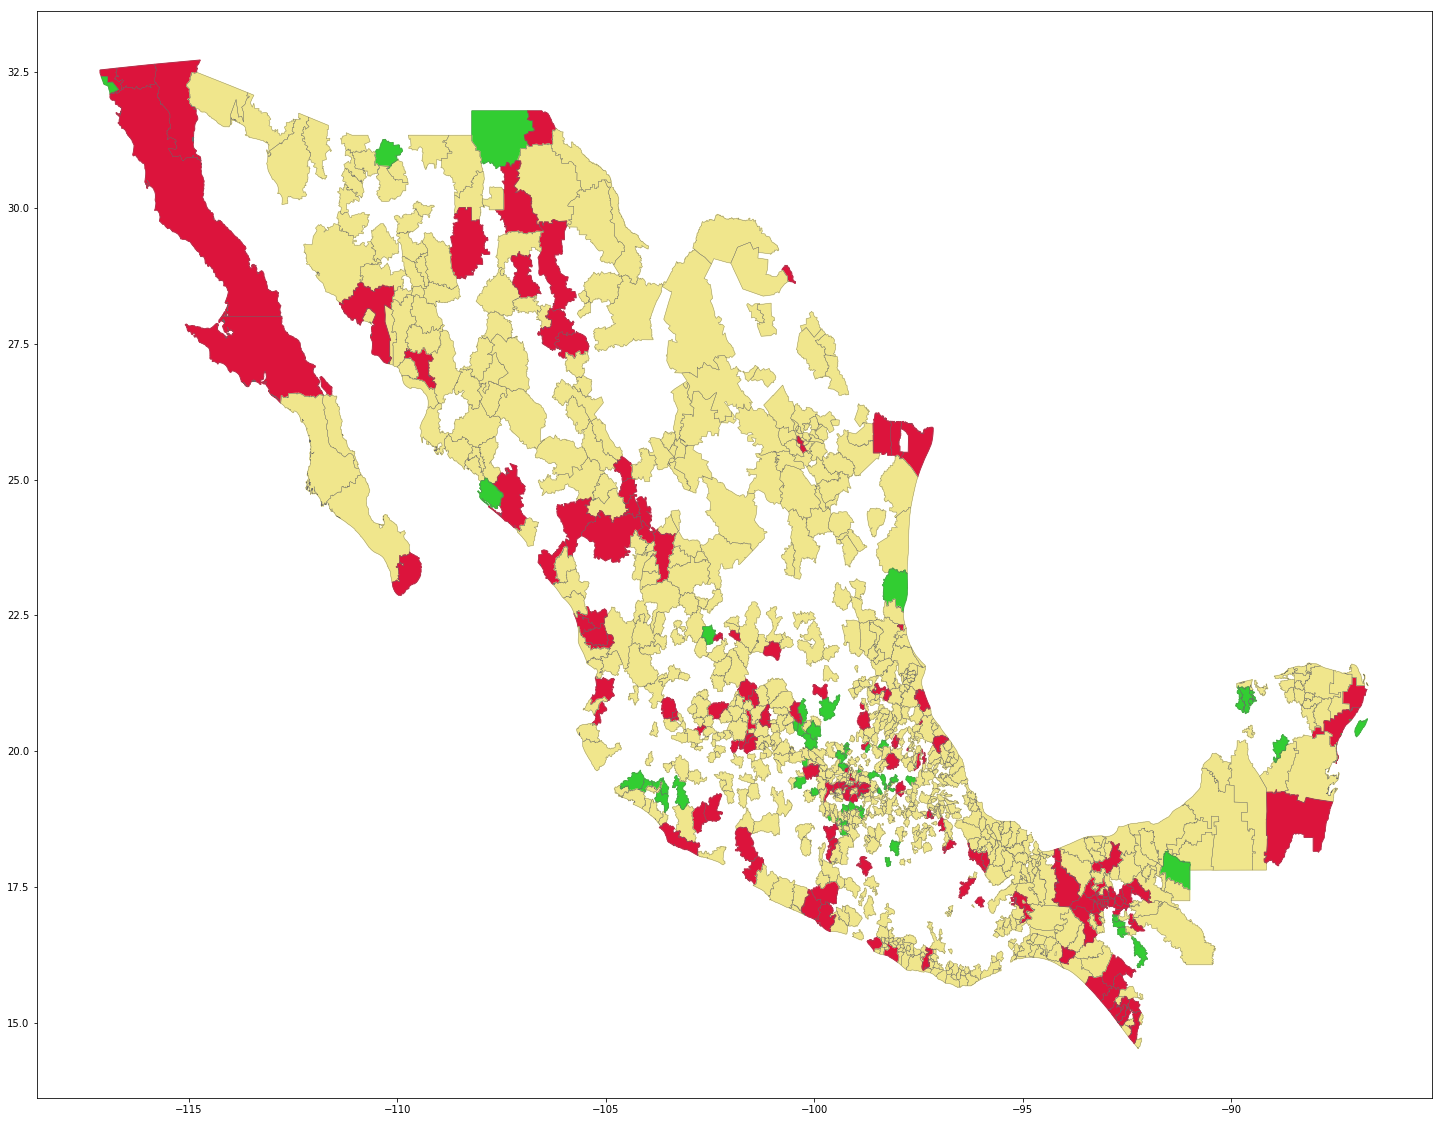

In [160]:
plt.show()

In [161]:
mun_count = 0
for vul in floods_risk_mun:
    if vul != "ND":
        mun_count += len(floods_risk_mun[vul])

floods_risk_mun.pop("ND")
for vul in floods_risk_mun:
    len_vul = len(floods_risk_mun[vul])
    print(f"Municipios con vulnerabilidad {vul:>5} (%): {len_vul / mun_count:.2%}")

Municipios con vulnerabilidad MEDIA (%): 77.46%
Municipios con vulnerabilidad  ALTA (%): 15.90%
Municipios con vulnerabilidad  BAJA (%): 6.65%


De los munipicios con los que si se cuenta con información, al rededor del 77% de estos se encuentra en vulnerabilidad media; 16% en alta y el 7% en baja.

In [162]:
floods_risk_mun["BAJA"]

['PLAYAS DE ROSARITO (BCN)',
 'ASCENSION (CHI)',
 'CANANEA (SON)',
 'NAVOLATO (SIN)',
 'TONATICO (MEX)',
 'COATLAN DEL RIO (MOR)',
 'SAN CRISTOBAL DE LAS CASAS (CHS)',
 'ALDAMA (TAM)',
 'SAN JOSE DE GRACIA (AGS)',
 'UCU (YUC)',
 'MERIDA (YUC)',
 'TEPOZTLAN (MOR)',
 'COMALA (COL)',
 'APETATITLAN DE ANTONIO CARVAJAL (TLA)',
 'ATLATLAHUCAN (MOR)',
 'TLAYACAPAN (MOR)',
 'YECAPIXTLA (MOR)',
 'CUERNAVACA (MOR)',
 'TECALITLAN (JAL)',
 'PANOTLA (TLA)',
 'BENITO JUAREZ (D-F)',
 'TULANCINGO DE BRAVO (HGO)',
 'ATOTONILCO DE TULA (HGO)',
 'HUIMILPAN (QRO)',
 'ZITACUARO (MIC)',
 'LIBRES (PUE)',
 'TLALPUJAHUA (MIC)',
 'TEPEJI DEL RIO DE OCAMPO (HGO)',
 'COCOTITLAN (MEX)',
 'TLAHUELILPAN (HGO)',
 'KANASIN (YUC)',
 'UMAN (YUC)',
 'MARQUES, EL (QRO)',
 'ACOLMAN (MEX)',
 'COZUMEL (QTR)',
 'CORREGIDORA (QRO)',
 'TEPOTZOTLAN (MEX)',
 'MINERAL DE LA REFORMA (HGO)',
 'TIXPEHUAL (YUC)',
 'TLAXCOAPAN (HGO)',
 'AMEALCO DE BONFIL (QRO)',
 'COZUMEL (QTR)',
 'COZUMEL (QTR)',
 'PETO (YUC)',
 'ATITALAQUIA (HGO)',
 